In [3]:
from sklearn import datasets, svm
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

## The digits data

In [4]:
digits = datasets.load_digits()
digits.data.shape

(1797, 64)

So the dataset contains $1797$ handwritten digits as $8 \times 8 = 64$ pixel images. The first $100$ of the $1797$ digits are shown below: above the image of each handwritten digit stands its true value (the target variable).

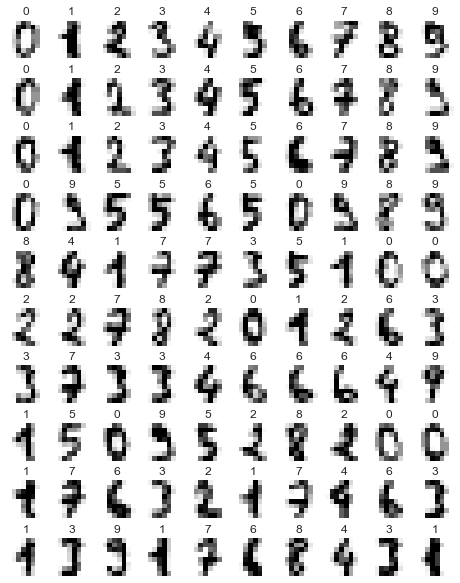

In [5]:
plt.style.use('seaborn-whitegrid')
nrow, ncol = (10, 10)
fig, ax = plt.subplots(nrow, ncol, figsize=2 * plt.figaspect(1.3))
for i in range(nrow * ncol):
    axi = ax[i // ncol, i % ncol]
    axi.imshow(np.reshape(digits.data[i], (8, 8)))
    axi.set_axis_off()
    axi.set_title(digits.target[i])

## Single score value: no cross-validation

1. manually partition input and output/target data into training and test set
1. train support vector machine classifier with linear kernel and $C=1$
1. calculate score

In [6]:
svc = svm.SVC(C=1.0, kernel='linear').fit(X=digits.data[:-100], y=digits.target[:-100])
svc.score(X=digits.data[-100:], y=digits.target[-100:])

0.98

## Manual cross-validation

1. split data into $k=3$ (roughly) equal-sized subsets
1. manually merge all but the $i$th subsets into a training set
1. train model on the training set
1. calculate score on the remaining, test set
1. repeat from step 2. with a different $i$

This is manual cross-validation

In [7]:
X_folds = np.array_split(digits.data, 3)
y_folds = np.array_split(digits.target, 3)
def threefoldCV(i):
    def splitdata(folds):
        data = folds.copy()
        test = data.pop(i)
        train = np.concatenate(data)
        d = {'train': train, 'test': test}
        return(d)
    X = splitdata(X_folds)
    y = splitdata(y_folds)
    svc = svm.SVC(C=1.0, kernel='linear')
    score = svc.fit(X=X['train'], y=y['train']).score(X=X['test'], y=y['test'])
    return(score)

[threefoldCV(i) for i in range(3)]

[0.9348914858096828, 0.9565943238731218, 0.9398998330550918]

## Automatic cross-validation

### Semi-autmatic using `model_selection.KFold`

1. use `model_selection.KFold.split(data)` to generate a sequence of training and test set indices
1. iterate over that sequence
1. at each iteration manually train model and calculate score 

In [8]:
from sklearn.model_selection import KFold, cross_val_score
def train_score(trainix, testix, dataset, estimator):
    X_train = dataset.data[trainix]
    X_test = dataset.data[testix]
    y_train = dataset.target[trainix]
    y_test = dataset.target[testix]
    estimator.fit(X=X_train, y=y_train)
    score = estimator.score(X=X_test, y=y_test)
    return(score)

svc = svm.SVC(1.0, kernel='linear')
fivefold = KFold(n_splits=5)
[train_score(train, test, digits, svc) for train, test in fivefold.split(digits.data)]

[0.9638888888888889,
 0.9222222222222223,
 0.9637883008356546,
 0.9637883008356546,
 0.9303621169916435]

### Fully-autmatic using `model_selection.cross_val_score`

1. do everything with one function call to `model_selection.cross_val_score`

In [9]:
svc = svm.SVC(1.0, kernel='linear')
cross_val_score(estimator=svc, X=digits.data, y=digits.target, cv=fivefold)

array([0.96388889, 0.92222222, 0.9637883 , 0.9637883 , 0.93036212])

## Exercise

On the digits dataset, plot the cross-validation score of a [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC) estimator with an linear kernel as a function of parameter C (use a logarithmic grid of points, from 1 to 10)

In [10]:
xx = 10.0 ** (np.linspace(-10, 0, 25))
scores = [cross_val_score(estimator=svm.SVC(C, kernel='linear'), X=digits.data, y=digits.target, cv=fivefold, n_jobs=-1) for C in xx]

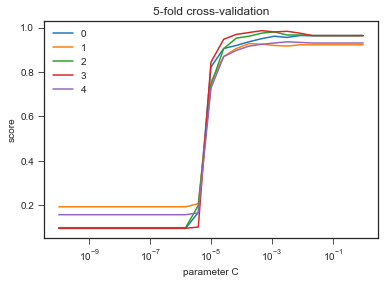

In [11]:
plt.style.use('seaborn-ticks')
yy = np.array(scores)
fig, ax = plt.subplots(1)
for i in range(yy.shape[1]):
    ax.plot(xx, yy[:,i])
ax.set_xscale('log')
ax.set_xlabel('parameter C')
ax.set_ylabel('score')
ax.set_title('5-fold cross-validation')
ax.legend(tuple(str(i) for i in range(yy.shape[1])))

## Grid-search and cross-validated estimators

In [12]:
from sklearn.model_selection import GridSearchCV
cls = GridSearchCV(estimator=svm.SVC(gamma='scale'), param_grid={'C': np.logspace(-6, -1, 100), 'kernel': ['linear', 'poly', 'sigmoid', 'rbf']}, n_jobs=-1, cv=5, iid=False)
cls.fit(X=digits.data[:1000], y=digits.target[:1000])

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid=False, n_jobs=-1,
             param_grid={'C': array([1.00000000e-06, 1.12332403e-06, 1.26185688...
       1.74752840e-02, 1.96304065e-02, 2.20513074e-02, 2.47707636e-02,
       2.78255940e-02, 3.12571585e-02, 3.51119173e-02, 3.94420606e-02,
       4.43062146e-02, 4.97702356e-02, 5.59081018e-02, 6.28029144e-02,
       7.05480231e-02, 7.92482898e-02, 8.90215085e-02, 1.00000000e-01]),
                         'kernel': ['linear', 'poly', 'sigmoid', 'rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [13]:
{'C': cls.best_estimator_.C, 'kernel': cls.best_estimator_.kernel}

{'C': 0.0030538555088334154, 'kernel': 'linear'}

### Exercise

On the diabetes dataset, find the optimal regularization parameter alpha.

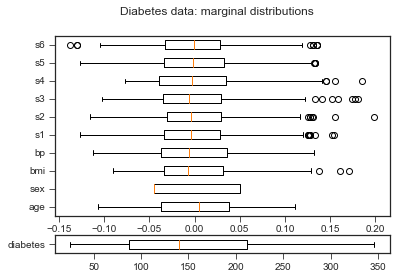

In [14]:
diabetes = datasets.load_diabetes()
fig = plt.figure()
fig.suptitle('Diabetes data: marginal distributions')
gs = fig.add_gridspec(nrows=2, ncols=1, height_ratios=[10, 1])
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[1, 0])
boxw = 0.5
bp0 = ax0.boxplot(diabetes.data, vert=False, labels=diabetes.feature_names, widths=boxw)
bp1 = ax1.boxplot(diabetes.target, vert=False, labels=['diabetes'], widths=boxw)

In [15]:
from sklearn import linear_model
reg = linear_model.LassoCV(n_jobs=-1, cv=5, random_state=1976)
reg.fit(X=diabetes.data, y=diabetes.target)

LassoCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
        max_iter=1000, n_alphas=100, n_jobs=-1, normalize=False, positive=False,
        precompute='auto', random_state=1976, selection='cyclic', tol=0.0001,
        verbose=False)

In [16]:
reg.alpha_

0.003753767152692203

In [17]:
reg1 = GridSearchCV(estimator=linear_model.Lasso(), param_grid={'alpha': reg.alphas_}, n_jobs=-1, cv=5, iid=False)
reg1.fit(X=diabetes.data, y=diabetes.target)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid=False, n_jobs=-1,
             param_grid={'alpha': array([2.14804358e+00, 2.00327263e+00, 1.86825876e+00, 1.74234437e+00,
       1.624916...
       8.08724617e-03, 7.54219285e-03, 7.03387429e-03, 6.55981471e-03,
       6.11770515e-03, 5.70539230e-03, 5.32086795e-03, 4.96225926e-03,
       4.62781959e-03, 4.31592004e-03, 4.02504148e-03, 3.75376715e-03,
       3.50077581e-03, 3.26483524e-03, 3.04479627e-03, 2.83958719e-03,
       2.64820852e-03, 2.46972813e-03, 2.30327672e-03, 2.14804358e-03])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [18]:
reg1.best_params_

{'alpha': 0.003753767152692203}

`reg1` returned by `model_selection.GridSearchCV` gets attribute `cv_results_` after the fit.  (The same attribute is absent in `reg` returned by `linear_model.LassoCV`.)

In [19]:
reg1.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_alpha', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

Text(0.5, 0, 'parameter $\\alpha$')

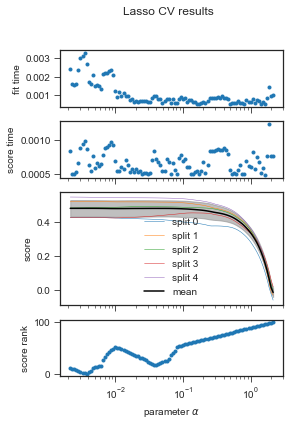

In [20]:
fig, ax = plt.subplots(4, 1, sharex=True, figsize=(plt.figaspect(1.5)), gridspec_kw={'height_ratios': [1, 1, 2, 1]})
fig.suptitle('Lasso CV results')
ax[0].set_xscale('log')
ax[0].plot('param_alpha', 'mean_fit_time', '.', data=reg1.cv_results_)
ax[0].set_ylabel('fit time')
ax[1].plot('param_alpha', 'mean_score_time', '.', data=reg1.cv_results_)
ax[1].set_ylabel('score time')
alphas = list(reg1.cv_results_['param_alpha'])
mean_score = reg1.cv_results_['mean_test_score']
std_score = reg1.cv_results_['std_test_score']
ax[2].fill_between(alphas, mean_score + std_score, mean_score - std_score, color='gray', alpha=0.5)
for i in range(reg1.cv):
    ax[2].plot('param_alpha', 'split' + str(i) + '_test_score', '-', linewidth=0.5, data=reg1.cv_results_)
ax[2].plot('param_alpha', 'mean_test_score', '-k', data=reg1.cv_results_)
ax[2].legend(['split ' + str(i) for i in range(reg1.cv)] + ['mean'])
ax[2].set_ylabel('score')
ax[3].plot('param_alpha', 'rank_test_score', '.', data=reg1.cv_results_)
ax[3].set_ylabel('score rank')
ax[3].set_xlabel('parameter $\\alpha$')

In [21]:
%connect_info

{
  "shell_port": 47497,
  "iopub_port": 46575,
  "stdin_port": 39735,
  "control_port": 41423,
  "hb_port": 38421,
  "ip": "127.0.0.1",
  "key": "b3712124-b8a1052b5c6e71157e3e785c",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-55afc05b-90e6-4920-bfdb-02d3cdf45f49.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
